## Physics Informed Neural Networks to Approximate Solution of PDEs

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import torch
from torch.utils.data import DataLoader
from Common import NeuralNet, MultiVariatePoly
import time
torch.manual_seed(128)

Consider the one-dimensional heat equation:

$$
u_t(t, x) = u_{xx}(t, x), \quad t\in[0,T], ~x\in [-1,1]
$$


with zero Dirichlet boundary conditions

$$
u_b(t, -1)=u_b(t,1)=0, 
$$

and initial condition

$$
u(x, 0) = u_0(x) = - \sin(\pi x)
$$

We want to obtain an approximate solution of the heat equation $u : [0,T]\times[-1,1] \mapsto \mathbb{R}$ with physics informed neural networks (PINNs).

To do so, we approximate the underlying solution with a feedforward dense neural network with tunable parameters $\theta$:

$$
u_\theta(t,x) \approx u(t,x)
$$
Define the following residuals:

   - Interior residual given by,

   $$r_{int,\theta}(t, x):=  u_{\theta, t}(x,t) - u_{\theta, xx}(x,t), \quad \forall ~t \in [0,T],~ x \in [-1,1].$$
   
        
      
        
   - Spatial boundary residual given by,
   
        $$r_{sb,\theta}(t,-1):= u_{\theta}(t,-1)- u_b(t,-1), \quad r_{sb,\theta}(t,1):= u_{\theta}(t,1)- u_b(t,1), \quad \forall t \in (0,T].$$
        
   - Temporal boundary residual given by,
   
        $$r_{tb,\theta}(x):= u_{\theta}(x,0) - u_0(x), \quad \forall x \in [-1,1].$$

and compute the corresponding loss functions:

$$
L_{int}(\theta) = \int_{[0,T]\times[-1,1]}r_{int,\theta}^2(t, x) dtdx, \quad
L_{sb}(\theta) = \int_{[0,T]}r_{sb,\theta}^2(t,-1) dt + \int_{[0,T]}r_{sb,\theta}^2(t,1)dt, \quad
L_{tb}(\theta) = \int_{[-1,1]}r_{tb,\theta}^2(x) dx
$$

The loss functions include integrals that can be approximated by suitable quadrature rule. We use quasi Monte-Carlo and accordingly define the following training sets

$$
S_{int} =\{y_n\}, \quad 1 \leq n \leq N_{int},\quad y_n = (x,t)_n \in D_T,
$$

$$
S_{sb, -1} =\{t_n, u_b(t_n,-1) \}, \quad1 \leq n \leq N_{sb}, t_n \in [0,T],
$$

$$
S_{sb, 1} =\{t_n, u_b(t_n,1) \}, \quad1 \leq n \leq N_{sb}, t_n \in [0,T],
$$

$$
S_{tb}=\{x_n, u_0(x_n)\}\quad  1 \leq n \leq N_{tb}, x_n \in [-1,1].
$$

with the training inputs points corresponding to low-discrepancy Sobol sequences.

$$
L_{int}(\theta) = \frac{1}{N_{int}}\sum_{i=1}^{N_{int}}r_{int,\theta}^2(y_n), \quad
L_{sb}(\theta) = \frac{1}{N_{sb}}\sum_{i=1}^{N_{sb}}r_{sb,\theta}^2(t_n,-1) + \frac{1}{N_{sb}}\sum_{i=1}^{N_{sb}}r_{sb,\theta}^2(t_n,1), \quad
L_{tb}(\theta) = \frac{1}{N_{tb}}\sum_{i=1}^{N_{tb}}r_{tb,\theta}^2(x_n)
$$

and solve the following minimization problem

$$
\theta^\ast = argmin_{\theta} \Big(L_{int}(\theta) + \lambda_u L_u(\theta)\Big)
$$

with

$$
L_u(\theta) = L_{tb}(\theta) + L_{sb}(\theta)
$$



In [2]:
class Pinns:
    def __init__(self, n_int_, n_sb_, n_tb_):
        self.n_int = n_int_
        self.n_sb = n_sb_
        self.n_tb = n_tb_

        # Extrema of the solution domain (t,x) in [0,0.1]x[-1,1]
        self.domain_extrema = torch.tensor([[0, 0.6],  # Time dimension
                                            [-1, 1]])  # Space dimension

        # Number of space dimensions
        self.space_dimensions = 1

        # Parameter to balance role of data and PDE
        self.lambda_u = 10

        # F Dense NN to approximate the solution of the underlying heat equation
        self.approximate_solution = NeuralNet(input_dimension=self.domain_extrema.shape[0], output_dimension=1,
                                              n_hidden_layers=4,
                                              neurons=20,
                                              regularization_param=0.,
                                              regularization_exp=2.,
                                              retrain_seed=42)
        '''self.approximate_solution = MultiVariatePoly(self.domain_extrema.shape[0], 3)'''

        # Generator of Sobol sequences
        self.soboleng = torch.quasirandom.SobolEngine(dimension=self.domain_extrema.shape[0])

        # Training sets S_sb, S_tb, S_int as torch dataloader
        self.training_set_sb, self.training_set_tb, self.training_set_int = self.assemble_datasets()

    ################################################################################################
    # Function to linearly transform a tensor whose value are between 0 and 1
    # to a tensor whose values are between the domain extrema
    def convert(self, tens):
        assert (tens.shape[1] == self.domain_extrema.shape[0])
        return tens * (self.domain_extrema[:, 1] - self.domain_extrema[:, 0]) + self.domain_extrema[:, 0]

    # Initial condition to solve the heat equation u0(x)=-sin(pi x)
    def initial_condition(self, x):
        return -torch.sin(np.pi * x)

    # Exact solution for the heat equation ut = u_xx with the IC above
    def exact_solution(self, inputs):
        t = inputs[:, 0]
        x = inputs[:, 1]

        u = -torch.exp(-np.pi ** 2 * t) * torch.sin(np.pi * x)
        return u

    ################################################################################################
    # Function returning the input-output tensor required to assemble the training set S_tb corresponding to the temporal boundary
    def add_temporal_boundary_points(self):
        t0 = self.domain_extrema[0, 0]
        input_tb = self.convert(self.soboleng.draw(self.n_tb))
        input_tb[:, 0] = torch.full(input_tb[:, 0].shape, t0)
        output_tb = self.initial_condition(input_tb[:, 1]).reshape(-1, 1)

        return input_tb, output_tb

    # Function returning the input-output tensor required to assemble the training set S_sb corresponding to the spatial boundary
    def add_spatial_boundary_points(self):
        x0 = self.domain_extrema[1, 0]
        xL = self.domain_extrema[1, 1]

        input_sb = self.convert(self.soboleng.draw(self.n_sb))

        input_sb_0 = torch.clone(input_sb)
        input_sb_0[:, 1] = torch.full(input_sb_0[:, 1].shape, x0)

        input_sb_L = torch.clone(input_sb)
        input_sb_L[:, 1] = torch.full(input_sb_L[:, 1].shape, xL)

        output_sb_0 = torch.zeros((input_sb.shape[0], 1))
        output_sb_L = torch.zeros((input_sb.shape[0], 1))

        return torch.cat([input_sb_0, input_sb_L], 0), torch.cat([output_sb_0, output_sb_L], 0)

    #  Function returning the input-output tensor required to assemble the training set S_int corresponding to the interior domain where the PDE is enforced
    def add_interior_points(self):
        input_int = self.convert(self.soboleng.draw(self.n_int))
        output_int = torch.zeros((input_int.shape[0], 1))
        return input_int, output_int

    # Function returning the training sets S_sb, S_tb, S_int as dataloader
    def assemble_datasets(self):
        input_sb, output_sb = self.add_spatial_boundary_points()   # S_sb
        input_tb, output_tb = self.add_temporal_boundary_points()  # S_tb
        input_int, output_int = self.add_interior_points()         # S_int

        training_set_sb = DataLoader(torch.utils.data.TensorDataset(input_sb, output_sb), batch_size=2*self.space_dimensions*self.n_sb, shuffle=False)
        training_set_tb = DataLoader(torch.utils.data.TensorDataset(input_tb, output_tb), batch_size=self.n_tb, shuffle=False)
        training_set_int = DataLoader(torch.utils.data.TensorDataset(input_int, output_int), batch_size=self.n_int, shuffle=False)

        return training_set_sb, training_set_tb, training_set_int

    ################################################################################################
    # Function to compute the terms required in the definition of the TEMPORAL boundary residual
    def apply_initial_condition(self, input_tb):
        u_pred_tb = self.approximate_solution(input_tb)
        return u_pred_tb

    # Function to compute the terms required in the definition of the SPATIAL boundary residual
    def apply_boundary_conditions(self, input_sb):
        u_pred_sb = self.approximate_solution(input_sb)

        return u_pred_sb

    # Function to compute the PDE residuals
    def compute_pde_residual(self, input_int):
        input_int.requires_grad = True
        u = self.approximate_solution(input_int)

        # grad compute the gradient of a "SCALAR" function L with respect to some input nxm TENSOR Z=[[x1, y1],[x2,y2],[x3,y3],...,[xn,yn]], m=2
        # it returns grad_L = [[dL/dx1, dL/dy1],[dL/dx2, dL/dy2],[dL/dx3, dL/dy3],...,[dL/dxn, dL/dyn]]
        # Note: pytorch considers a tensor [u1, u2,u3, ... ,un] a vectorial function
        # whereas sum_u = u1 + u2 + u3 + u4 + ... + un as a "scalar" one

        # In our case ui = u(xi), therefore the line below returns:
        # grad_u = [[dsum_u/dx1, dsum_u/dy1],[dsum_u/dx2, dsum_u/dy2],[dsum_u/dx3, dL/dy3],...,[dsum_u/dxm, dsum_u/dyn]]
        # and dsum_u/dxi = d(u1 + u2 + u3 + u4 + ... + un)/dxi = d(u(x1) + u(x2) u3(x3) + u4(x4) + ... + u(xn))/dxi = dui/dxi
        grad_u = torch.autograd.grad(u.sum(), input_int, create_graph=True)[0]
        grad_u_t = grad_u[:, 0]
        grad_u_x = grad_u[:, 1]
        grad_u_xx = torch.autograd.grad(grad_u_x.sum(), input_int, create_graph=True)[0][:, 1]

        grad_u_sq_x = torch.autograd.grad(grad_u_xx.sum(), input_int, create_graph=True)[0][:,1]

        residual = grad_u_t - grad_u_xx
        return residual.reshape(-1, )

    # Function to compute the total loss (weighted sum of spatial boundary loss, temporal boundary loss and interior loss)
    def compute_loss(self, inp_train_sb, u_train_sb, inp_train_tb, u_train_tb, inp_train_int, verbose=True):
        u_pred_sb = self.apply_boundary_conditions(inp_train_sb)
        u_pred_tb = self.apply_initial_condition(inp_train_tb)

        assert (u_pred_sb.shape[1] == u_train_sb.shape[1])
        assert (u_pred_tb.shape[1] == u_train_tb.shape[1])


        r_int = self.compute_pde_residual(inp_train_int)
        r_sb = u_train_sb - u_pred_sb
        r_tb = u_train_tb - u_pred_tb

        loss_sb = torch.mean(abs(r_sb) ** 2)
        loss_tb = torch.mean(abs(r_tb) ** 2)
        loss_int = torch.mean(abs(r_int) ** 2)

        loss_u = loss_sb + loss_tb

        loss = torch.log10(self.lambda_u * (loss_sb + loss_tb) + loss_int)
        if verbose: print("Total loss: ", round(loss.item(), 4), "| PDE Loss: ", round(torch.log10(loss_u).item(), 4), "| Function Loss: ", round(torch.log10(loss_int).item(), 4))

        return loss

    ################################################################################################
    def fit(self, num_epochs, optimizer, verbose=True):
        history = list()

        # Loop over epochs
        for epoch in range(num_epochs):
            if verbose: print("################################ ", epoch, " ################################")

            for j, ((inp_train_sb, u_train_sb), (inp_train_tb, u_train_tb), (inp_train_int, u_train_int)) in enumerate(zip(self.training_set_sb, self.training_set_tb, self.training_set_int)):
                def closure():
                    optimizer.zero_grad()
                    loss = self.compute_loss(inp_train_sb, u_train_sb, inp_train_tb, u_train_tb, inp_train_int, verbose=verbose)
                    loss.backward()

                    history.append(loss.item())
                    return loss

                optimizer.step(closure=closure)

        print('Final Loss: ', history[-1])

        return history

    ################################################################################################
    def plotting(self):
        inputs = self.soboleng.draw(100000)
        inputs = self.convert(inputs)

        output = self.approximate_solution(inputs).reshape(-1, )
        exact_output = self.exact_solution(inputs).reshape(-1, )

        fig, axs = plt.subplots(1, 2, figsize=(16, 8), dpi=150)
        im1 = axs[0].scatter(inputs[:, 1].detach(), inputs[:, 0].detach(), c=exact_output.detach(), cmap="jet")
        axs[0].set_xlabel("x")
        axs[0].set_ylabel("t")
        plt.colorbar(im1, ax=axs[0])
        axs[0].grid(True, which="both", ls=":")
        im2 = axs[1].scatter(inputs[:, 1].detach(), inputs[:, 0].detach(), c=output.detach(), cmap="jet")
        axs[1].set_xlabel("x")
        axs[1].set_ylabel("t")
        plt.colorbar(im2, ax=axs[1])
        axs[1].grid(True, which="both", ls=":")
        axs[0].set_title("Exact Solution")
        axs[1].set_title("Approximate Solution")

        plt.show()

        err = (torch.mean((output - exact_output) ** 2) / torch.mean(exact_output ** 2)) ** 0.5 * 100
        print("L2 Relative Error Norm: ", err.item(), "%")


In [3]:
# Solve the heat equation:
# u_t = u_xx, (t,x) in [0, 0.1]x[-1,1]
# with zero dirichlet BC and
# u(x,0)= -sin(pi x)

n_int = 256
n_sb = 64
n_tb = 64

pinn = Pinns(n_int, n_sb, n_tb)

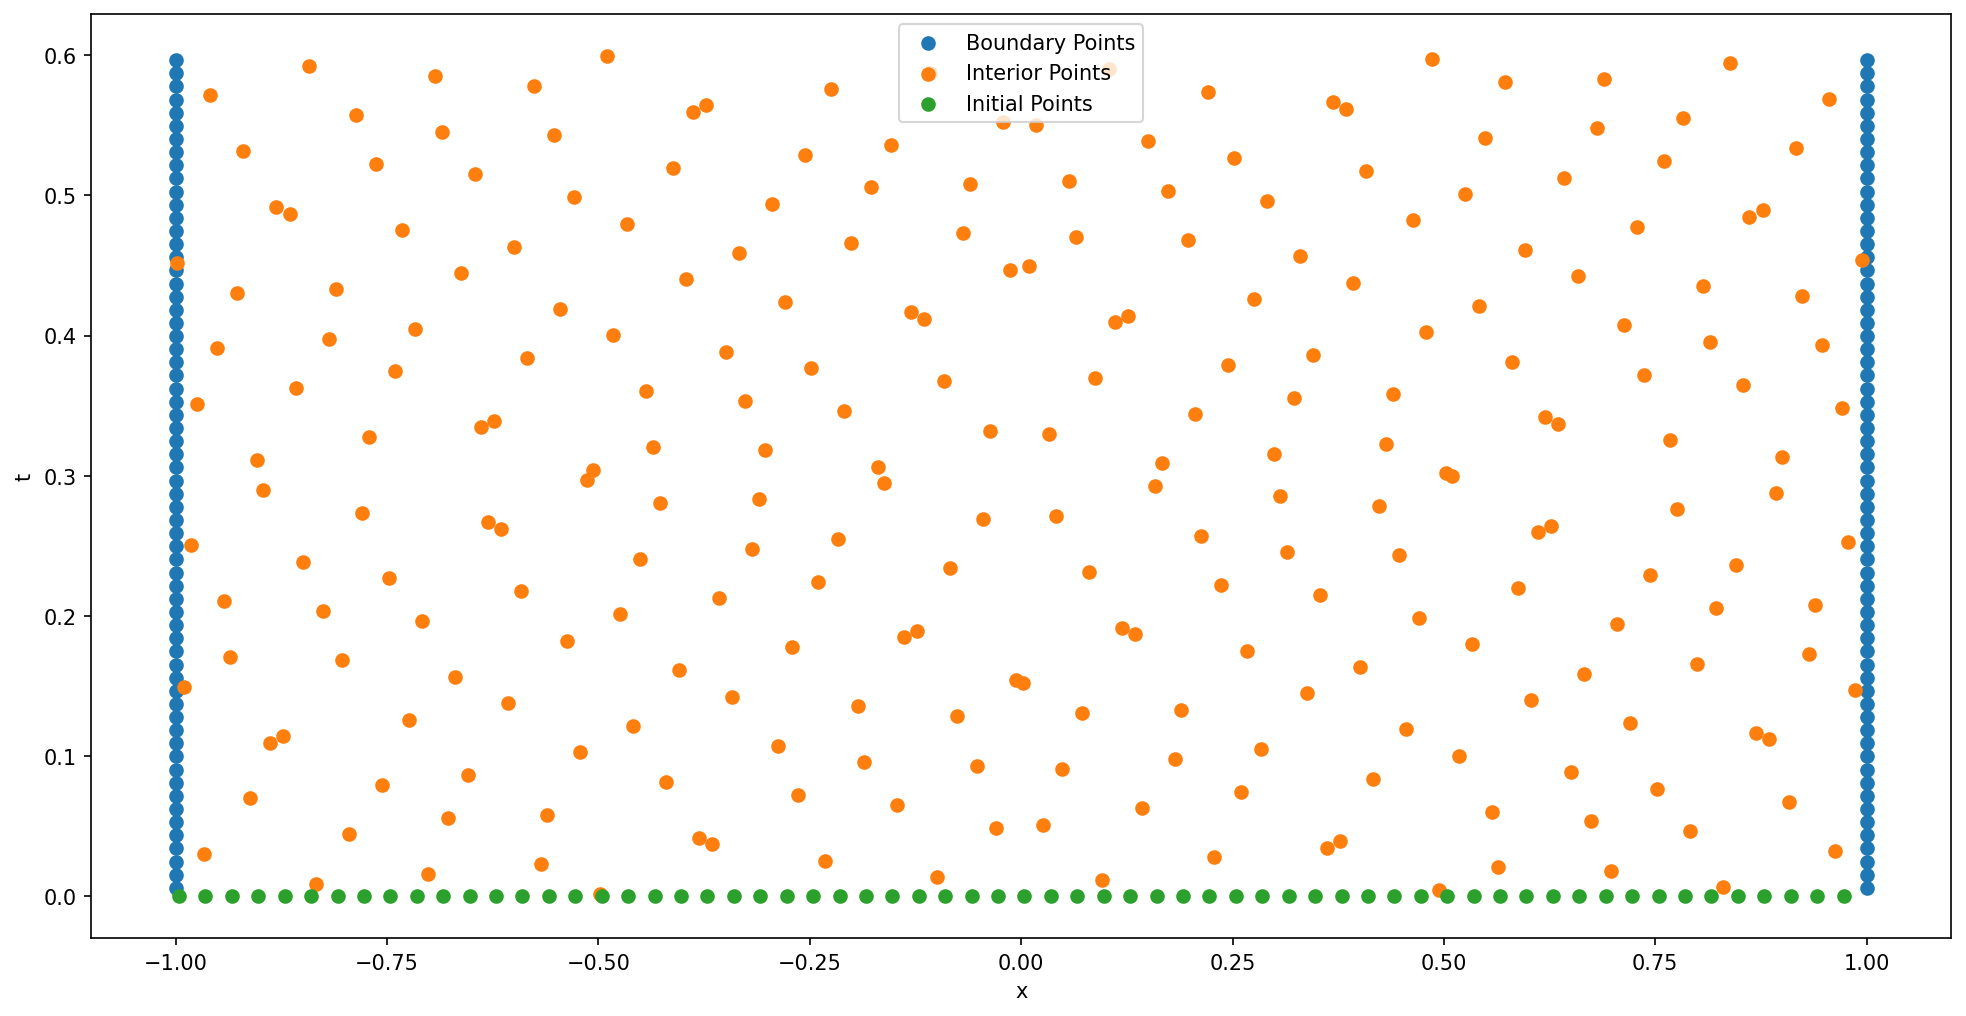

In [4]:
# Plot the input training points
input_sb_, output_sb_ = pinn.add_spatial_boundary_points()
input_tb_, output_tb_ = pinn.add_temporal_boundary_points()
input_int_, output_int_ = pinn.add_interior_points()

plt.figure(figsize=(16, 8), dpi=150)
plt.scatter(input_sb_[:, 1].detach().numpy(), input_sb_[:, 0].detach().numpy(), label="Boundary Points")
plt.scatter(input_int_[:, 1].detach().numpy(), input_int_[:, 0].detach().numpy(), label="Interior Points")
plt.scatter(input_tb_[:, 1].detach().numpy(), input_tb_[:, 0].detach().numpy(), label="Initial Points")
plt.xlabel("x")
plt.ylabel("t")
plt.legend()
plt.show()

In [5]:
n_epochs = 1
optimizer_LBFGS = optim.LBFGS(pinn.approximate_solution.parameters(),
                              lr=float(0.5),
                              max_iter=50000,
                              max_eval=50000,
                              history_size=150,
                              line_search_fn="strong_wolfe",
                              tolerance_change=1.0 * np.finfo(float).eps)
optimizer_ADAM = optim.Adam(pinn.approximate_solution.parameters(),
                            lr=float(0.001))

################################  0  ################################
Total loss:  1.5613 | PDE Loss:  0.3077 | Function Loss:  1.2072
Total loss:  1.4913 | PDE Loss:  0.226 | Function Loss:  1.1513
Total loss:  1.2927 | PDE Loss:  0.1691 | Function Loss:  0.6867
Total loss:  1.1611 | PDE Loss:  0.0286 | Function Loss:  0.5811
Total loss:  1.5439 | PDE Loss:  0.4642 | Function Loss:  0.7685
Total loss:  0.9226 | PDE Loss:  -0.2081 | Function Loss:  0.3374
Total loss:  0.8295 | PDE Loss:  -0.2897 | Function Loss:  0.2098
Total loss:  0.6848 | PDE Loss:  -0.4076 | Function Loss:  -0.0329
Total loss:  0.6451 | PDE Loss:  -0.4317 | Function Loss:  -0.1451
Total loss:  0.5332 | PDE Loss:  -0.5277 | Function Loss:  -0.3503
Total loss:  0.4889 | PDE Loss:  -0.5868 | Function Loss:  -0.3072
Total loss:  0.4244 | PDE Loss:  -0.6602 | Function Loss:  -0.3277
Total loss:  0.3654 | PDE Loss:  -0.7158 | Function Loss:  -0.4028
Total loss:  0.3375 | PDE Loss:  -0.7474 | Function Loss:  -0.4131
Total

Total loss:  -2.2549 | PDE Loss:  -4.044 | Function Loss:  -2.332
Total loss:  -2.2628 | PDE Loss:  -4.0154 | Function Loss:  -2.3472
Total loss:  -2.2701 | PDE Loss:  -4.0339 | Function Loss:  -2.3522
Total loss:  -2.2776 | PDE Loss:  -4.013 | Function Loss:  -2.3659
Total loss:  -2.2862 | PDE Loss:  -4.0345 | Function Loss:  -2.3716
Total loss:  -2.3035 | PDE Loss:  -4.1116 | Function Loss:  -2.3769
Total loss:  -2.3184 | PDE Loss:  -4.1703 | Function Loss:  -2.3842
Total loss:  -2.3345 | PDE Loss:  -4.2007 | Function Loss:  -2.398
Total loss:  -2.3474 | PDE Loss:  -4.1774 | Function Loss:  -2.4169
Total loss:  -2.3584 | PDE Loss:  -4.1698 | Function Loss:  -2.4313
Total loss:  -2.3699 | PDE Loss:  -4.1632 | Function Loss:  -2.4461
Total loss:  -2.3846 | PDE Loss:  -4.1657 | Function Loss:  -2.4632
Total loss:  -2.405 | PDE Loss:  -4.1342 | Function Loss:  -2.4947
Total loss:  -2.4317 | PDE Loss:  -4.1482 | Function Loss:  -2.5243
Total loss:  -2.4517 | PDE Loss:  -4.1489 | Function 

Total loss:  -3.2329 | PDE Loss:  -5.1141 | Function Loss:  -3.2941
Total loss:  -3.2356 | PDE Loss:  -5.1195 | Function Loss:  -3.2964
Total loss:  -3.2407 | PDE Loss:  -5.1212 | Function Loss:  -3.302
Total loss:  -3.2492 | PDE Loss:  -5.1347 | Function Loss:  -3.3097
Total loss:  -3.2626 | PDE Loss:  -5.1536 | Function Loss:  -3.3223
Total loss:  -3.2809 | PDE Loss:  -5.1706 | Function Loss:  -3.3408
Total loss:  -3.2993 | PDE Loss:  -5.1821 | Function Loss:  -3.3603
Total loss:  -3.3122 | PDE Loss:  -5.1763 | Function Loss:  -3.376
Total loss:  -3.3197 | PDE Loss:  -5.1774 | Function Loss:  -3.3846
Total loss:  -3.3223 | PDE Loss:  -5.1744 | Function Loss:  -3.3881
Total loss:  -3.3236 | PDE Loss:  -5.1762 | Function Loss:  -3.3893
Total loss:  -3.3243 | PDE Loss:  -5.1784 | Function Loss:  -3.3898
Total loss:  -3.3248 | PDE Loss:  -5.1797 | Function Loss:  -3.3902
Total loss:  -3.3255 | PDE Loss:  -5.1807 | Function Loss:  -3.3908
Total loss:  -3.3264 | PDE Loss:  -5.1818 | Functi

Total loss:  -3.7827 | PDE Loss:  -5.2132 | Function Loss:  -3.9841
Total loss:  -3.787 | PDE Loss:  -5.2177 | Function Loss:  -3.9884
Total loss:  -3.7908 | PDE Loss:  -5.2174 | Function Loss:  -3.9946
Total loss:  -3.7936 | PDE Loss:  -5.2166 | Function Loss:  -3.9995
Total loss:  -3.7949 | PDE Loss:  -5.216 | Function Loss:  -4.002
Total loss:  -3.7955 | PDE Loss:  -5.2163 | Function Loss:  -4.0028
Total loss:  -3.7959 | PDE Loss:  -5.2173 | Function Loss:  -4.0027
Total loss:  -3.7963 | PDE Loss:  -5.2188 | Function Loss:  -4.0025
Total loss:  -3.7969 | PDE Loss:  -5.2216 | Function Loss:  -4.0018
Total loss:  -3.7976 | PDE Loss:  -5.2243 | Function Loss:  -4.0012
Total loss:  -3.7982 | PDE Loss:  -5.2249 | Function Loss:  -4.0018
Total loss:  -3.799 | PDE Loss:  -5.2249 | Function Loss:  -4.0032
Total loss:  -3.7999 | PDE Loss:  -5.223 | Function Loss:  -4.0058
Total loss:  -3.8008 | PDE Loss:  -5.2197 | Function Loss:  -4.0093
Total loss:  -3.8019 | PDE Loss:  -5.2164 | Function 

Total loss:  -4.1709 | PDE Loss:  -5.6349 | Function Loss:  -4.3537
Total loss:  -4.1725 | PDE Loss:  -5.6336 | Function Loss:  -4.3568
Total loss:  -4.175 | PDE Loss:  -5.6329 | Function Loss:  -4.3609
Total loss:  -4.1789 | PDE Loss:  -5.6313 | Function Loss:  -4.3678
Total loss:  -4.184 | PDE Loss:  -5.6294 | Function Loss:  -4.3769
Total loss:  -4.1901 | PDE Loss:  -5.6281 | Function Loss:  -4.3872
Total loss:  -4.1953 | PDE Loss:  -5.6265 | Function Loss:  -4.3962
Total loss:  -4.2042 | PDE Loss:  -5.6296 | Function Loss:  -4.4086
Total loss:  -4.2122 | PDE Loss:  -5.6362 | Function Loss:  -4.4175
Total loss:  -4.2216 | PDE Loss:  -5.6458 | Function Loss:  -4.4268
Total loss:  -4.2253 | PDE Loss:  -5.6491 | Function Loss:  -4.4308
Total loss:  -4.2281 | PDE Loss:  -5.6537 | Function Loss:  -4.4325
Total loss:  -4.2304 | PDE Loss:  -5.6567 | Function Loss:  -4.4343
Total loss:  -4.2316 | PDE Loss:  -5.6576 | Function Loss:  -4.4358
Total loss:  -4.2329 | PDE Loss:  -5.6602 | Functi

Total loss:  -4.3931 | PDE Loss:  -5.7759 | Function Loss:  -4.6253
Total loss:  -4.3937 | PDE Loss:  -5.7765 | Function Loss:  -4.6259
Total loss:  -4.3945 | PDE Loss:  -5.7763 | Function Loss:  -4.6275
Total loss:  -4.3956 | PDE Loss:  -5.7758 | Function Loss:  -4.6297
Total loss:  -4.3969 | PDE Loss:  -5.7728 | Function Loss:  -4.6341
Total loss:  -4.3986 | PDE Loss:  -5.7701 | Function Loss:  -4.639
Total loss:  -4.4003 | PDE Loss:  -5.767 | Function Loss:  -4.6444
Total loss:  -4.4028 | PDE Loss:  -5.7626 | Function Loss:  -4.6521
Total loss:  -4.4055 | PDE Loss:  -5.7597 | Function Loss:  -4.6592
Total loss:  -4.4086 | PDE Loss:  -5.7577 | Function Loss:  -4.6663
Total loss:  -4.4118 | PDE Loss:  -5.756 | Function Loss:  -4.6736
Total loss:  -4.4151 | PDE Loss:  -5.7578 | Function Loss:  -4.6781
Total loss:  -4.4181 | PDE Loss:  -5.7609 | Function Loss:  -4.6811
Total loss:  -4.4215 | PDE Loss:  -5.7662 | Function Loss:  -4.6828
Total loss:  -4.4245 | PDE Loss:  -5.7742 | Functio

Total loss:  -4.5013 | PDE Loss:  -5.7835 | Function Loss:  -4.8221
Total loss:  -4.5018 | PDE Loss:  -5.7865 | Function Loss:  -4.8197
Total loss:  -4.5023 | PDE Loss:  -5.7855 | Function Loss:  -4.822
Total loss:  -4.5027 | PDE Loss:  -5.784 | Function Loss:  -4.8244
Total loss:  -4.503 | PDE Loss:  -5.7835 | Function Loss:  -4.8257
Total loss:  -4.5035 | PDE Loss:  -5.7835 | Function Loss:  -4.8266
Total loss:  -4.5039 | PDE Loss:  -5.7836 | Function Loss:  -4.8274
Total loss:  -4.5043 | PDE Loss:  -5.784 | Function Loss:  -4.8278
Total loss:  -4.5047 | PDE Loss:  -5.7847 | Function Loss:  -4.8278
Total loss:  -4.5052 | PDE Loss:  -5.7849 | Function Loss:  -4.8286
Total loss:  -4.5057 | PDE Loss:  -5.7865 | Function Loss:  -4.8279
Total loss:  -4.5061 | PDE Loss:  -5.788 | Function Loss:  -4.8272
Total loss:  -4.5066 | PDE Loss:  -5.7896 | Function Loss:  -4.8265
Total loss:  -4.507 | PDE Loss:  -5.7921 | Function Loss:  -4.8246
Total loss:  -4.5075 | PDE Loss:  -5.794 | Function Lo

Total loss:  -4.5963 | PDE Loss:  -5.967 | Function Loss:  -4.8372
Total loss:  -4.5974 | PDE Loss:  -5.9688 | Function Loss:  -4.8378
Total loss:  -4.5984 | PDE Loss:  -5.9705 | Function Loss:  -4.8383
Total loss:  -4.5992 | PDE Loss:  -5.9714 | Function Loss:  -4.8391
Total loss:  -4.6 | PDE Loss:  -5.9713 | Function Loss:  -4.8405
Total loss:  -4.6008 | PDE Loss:  -5.9717 | Function Loss:  -4.8417
Total loss:  -4.6016 | PDE Loss:  -5.9715 | Function Loss:  -4.8433
Total loss:  -4.6026 | PDE Loss:  -5.9722 | Function Loss:  -4.8444
Total loss:  -4.6038 | PDE Loss:  -5.9725 | Function Loss:  -4.8463
Total loss:  -4.6051 | PDE Loss:  -5.9738 | Function Loss:  -4.8476
Total loss:  -4.6066 | PDE Loss:  -5.9754 | Function Loss:  -4.8491
Total loss:  -4.6085 | PDE Loss:  -5.9766 | Function Loss:  -4.8515
Total loss:  -4.6105 | PDE Loss:  -5.9786 | Function Loss:  -4.8536
Total loss:  -4.6123 | PDE Loss:  -5.9771 | Function Loss:  -4.8578
Total loss:  -4.6141 | PDE Loss:  -5.9792 | Function

Total loss:  -4.6806 | PDE Loss:  -6.0549 | Function Loss:  -4.919
Total loss:  -4.6809 | PDE Loss:  -6.0556 | Function Loss:  -4.9189
Total loss:  -4.6811 | PDE Loss:  -6.0565 | Function Loss:  -4.9187
Total loss:  -4.6816 | PDE Loss:  -6.0572 | Function Loss:  -4.9189
Total loss:  -4.682 | PDE Loss:  -6.0586 | Function Loss:  -4.9187
Total loss:  -4.6823 | PDE Loss:  -6.0583 | Function Loss:  -4.9194
Total loss:  -4.6827 | PDE Loss:  -6.0588 | Function Loss:  -4.9198
Total loss:  -4.6831 | PDE Loss:  -6.058 | Function Loss:  -4.921
Total loss:  -4.6833 | PDE Loss:  -6.0572 | Function Loss:  -4.922
Total loss:  -4.6837 | PDE Loss:  -6.0567 | Function Loss:  -4.923
Total loss:  -4.6842 | PDE Loss:  -6.0551 | Function Loss:  -4.9251
Total loss:  -4.6848 | PDE Loss:  -6.0541 | Function Loss:  -4.9269
Total loss:  -4.6856 | PDE Loss:  -6.0531 | Function Loss:  -4.9291
Total loss:  -4.6867 | PDE Loss:  -6.0517 | Function Loss:  -4.9319
Total loss:  -4.6876 | PDE Loss:  -6.0497 | Function L

Total loss:  -4.7817 | PDE Loss:  -6.3492 | Function Loss:  -4.9188
Total loss:  -4.7838 | PDE Loss:  -6.3466 | Function Loss:  -4.9226
Total loss:  -4.7851 | PDE Loss:  -6.3455 | Function Loss:  -4.9249
Total loss:  -4.7865 | PDE Loss:  -6.344 | Function Loss:  -4.9273
Total loss:  -4.788 | PDE Loss:  -6.3425 | Function Loss:  -4.93
Total loss:  -4.7894 | PDE Loss:  -6.3429 | Function Loss:  -4.9319
Total loss:  -4.7909 | PDE Loss:  -6.3427 | Function Loss:  -4.9339
Total loss:  -4.7922 | PDE Loss:  -6.3434 | Function Loss:  -4.9356
Total loss:  -4.7939 | PDE Loss:  -6.3438 | Function Loss:  -4.9377
Total loss:  -4.7953 | PDE Loss:  -6.3451 | Function Loss:  -4.9392
Total loss:  -4.7963 | PDE Loss:  -6.3454 | Function Loss:  -4.9405
Total loss:  -4.7972 | PDE Loss:  -6.3462 | Function Loss:  -4.9414
Total loss:  -4.7981 | PDE Loss:  -6.3458 | Function Loss:  -4.9428
Total loss:  -4.7987 | PDE Loss:  -6.3451 | Function Loss:  -4.9439
Total loss:  -4.7993 | PDE Loss:  -6.3439 | Function

Total loss:  -4.8308 | PDE Loss:  -6.3155 | Function Loss:  -5.0031
Total loss:  -4.831 | PDE Loss:  -6.315 | Function Loss:  -5.0038
Total loss:  -4.8313 | PDE Loss:  -6.3148 | Function Loss:  -5.0042
Total loss:  -4.8314 | PDE Loss:  -6.3146 | Function Loss:  -5.0045
Total loss:  -4.8316 | PDE Loss:  -6.3143 | Function Loss:  -5.005
Total loss:  -4.8318 | PDE Loss:  -6.3138 | Function Loss:  -5.0054
Total loss:  -4.8319 | PDE Loss:  -6.3133 | Function Loss:  -5.0059
Total loss:  -4.8321 | PDE Loss:  -6.3116 | Function Loss:  -5.007
Total loss:  -4.8322 | PDE Loss:  -6.3116 | Function Loss:  -5.0071
Total loss:  -4.8322 | PDE Loss:  -6.3115 | Function Loss:  -5.0073
Total loss:  -4.8323 | PDE Loss:  -6.3115 | Function Loss:  -5.0074
Total loss:  -4.8324 | PDE Loss:  -6.3116 | Function Loss:  -5.0074
Total loss:  -4.8324 | PDE Loss:  -6.3115 | Function Loss:  -5.0075
Total loss:  -4.8325 | PDE Loss:  -6.3115 | Function Loss:  -5.0076
Total loss:  -4.8326 | PDE Loss:  -6.3115 | Function

Total loss:  -4.9568 | PDE Loss:  -6.478 | Function Loss:  -5.1125
Total loss:  -4.9576 | PDE Loss:  -6.477 | Function Loss:  -5.1141
Total loss:  -4.9584 | PDE Loss:  -6.4797 | Function Loss:  -5.114
Total loss:  -4.9592 | PDE Loss:  -6.4821 | Function Loss:  -5.114
Total loss:  -4.96 | PDE Loss:  -6.4859 | Function Loss:  -5.1136
Total loss:  -4.9608 | PDE Loss:  -6.4897 | Function Loss:  -5.1132
Total loss:  -4.9615 | PDE Loss:  -6.4937 | Function Loss:  -5.1125
Total loss:  -4.9621 | PDE Loss:  -6.4968 | Function Loss:  -5.112
Total loss:  -4.9628 | PDE Loss:  -6.4994 | Function Loss:  -5.1119
Total loss:  -4.9634 | PDE Loss:  -6.5018 | Function Loss:  -5.1118
Total loss:  -4.9639 | PDE Loss:  -6.5034 | Function Loss:  -5.1119
Total loss:  -4.9643 | PDE Loss:  -6.5041 | Function Loss:  -5.1121
Total loss:  -4.9648 | PDE Loss:  -6.505 | Function Loss:  -5.1125
Total loss:  -4.9653 | PDE Loss:  -6.5057 | Function Loss:  -5.1129
Total loss:  -4.9657 | PDE Loss:  -6.5067 | Function Los

Total loss:  -5.0453 | PDE Loss:  -6.62 | Function Loss:  -5.1798
Total loss:  -5.0455 | PDE Loss:  -6.6201 | Function Loss:  -5.18
Total loss:  -5.0456 | PDE Loss:  -6.6202 | Function Loss:  -5.18
Total loss:  -5.0457 | PDE Loss:  -6.6202 | Function Loss:  -5.1803
Total loss:  -5.0459 | PDE Loss:  -6.6209 | Function Loss:  -5.1803
Total loss:  -5.0461 | PDE Loss:  -6.6204 | Function Loss:  -5.1808
Total loss:  -5.0464 | PDE Loss:  -6.6207 | Function Loss:  -5.1809
Total loss:  -5.0467 | PDE Loss:  -6.621 | Function Loss:  -5.1813
Total loss:  -5.047 | PDE Loss:  -6.6219 | Function Loss:  -5.1814
Total loss:  -5.0473 | PDE Loss:  -6.6228 | Function Loss:  -5.1815
Total loss:  -5.0476 | PDE Loss:  -6.6239 | Function Loss:  -5.1815
Total loss:  -5.0479 | PDE Loss:  -6.6247 | Function Loss:  -5.1816
Total loss:  -5.0482 | PDE Loss:  -6.6259 | Function Loss:  -5.1815
Total loss:  -5.0485 | PDE Loss:  -6.6268 | Function Loss:  -5.1817
Total loss:  -5.0488 | PDE Loss:  -6.6276 | Function Los

Total loss:  -5.13 | PDE Loss:  -6.7728 | Function Loss:  -5.2422
Total loss:  -5.1319 | PDE Loss:  -6.769 | Function Loss:  -5.2457
Total loss:  -5.1334 | PDE Loss:  -6.7667 | Function Loss:  -5.2484
Total loss:  -5.1348 | PDE Loss:  -6.7661 | Function Loss:  -5.2503
Total loss:  -5.1358 | PDE Loss:  -6.7663 | Function Loss:  -5.2517
Total loss:  -5.137 | PDE Loss:  -6.7669 | Function Loss:  -5.253
Total loss:  -5.1381 | PDE Loss:  -6.7698 | Function Loss:  -5.2536
Total loss:  -5.1403 | PDE Loss:  -6.7737 | Function Loss:  -5.2553
Total loss:  -5.1433 | PDE Loss:  -6.7825 | Function Loss:  -5.2566
Total loss:  -5.1462 | PDE Loss:  -6.789 | Function Loss:  -5.2584
Total loss:  -5.1489 | PDE Loss:  -6.7954 | Function Loss:  -5.26
Total loss:  -5.1508 | PDE Loss:  -6.7985 | Function Loss:  -5.2616
Total loss:  -5.153 | PDE Loss:  -6.8006 | Function Loss:  -5.2637
Total loss:  -5.1547 | PDE Loss:  -6.8017 | Function Loss:  -5.2657
Total loss:  -5.1555 | PDE Loss:  -6.8027 | Function Loss

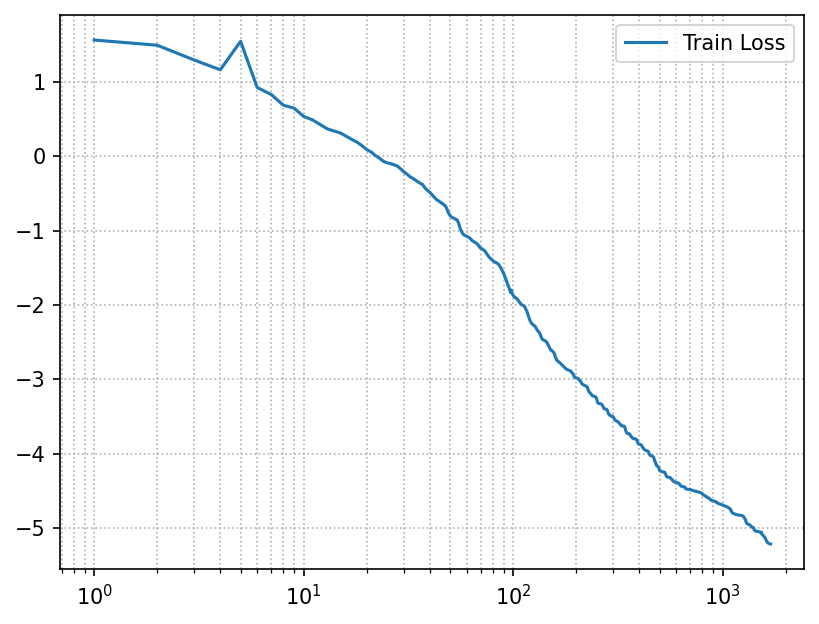

In [6]:
hist = pinn.fit(num_epochs=n_epochs,
                optimizer=optimizer_LBFGS,
                verbose=True)

plt.figure(dpi=150)
plt.grid(True, which="both", ls=":")
plt.plot(np.arange(1, len(hist) + 1), hist, label="Train Loss")
plt.xscale("log")
plt.legend()

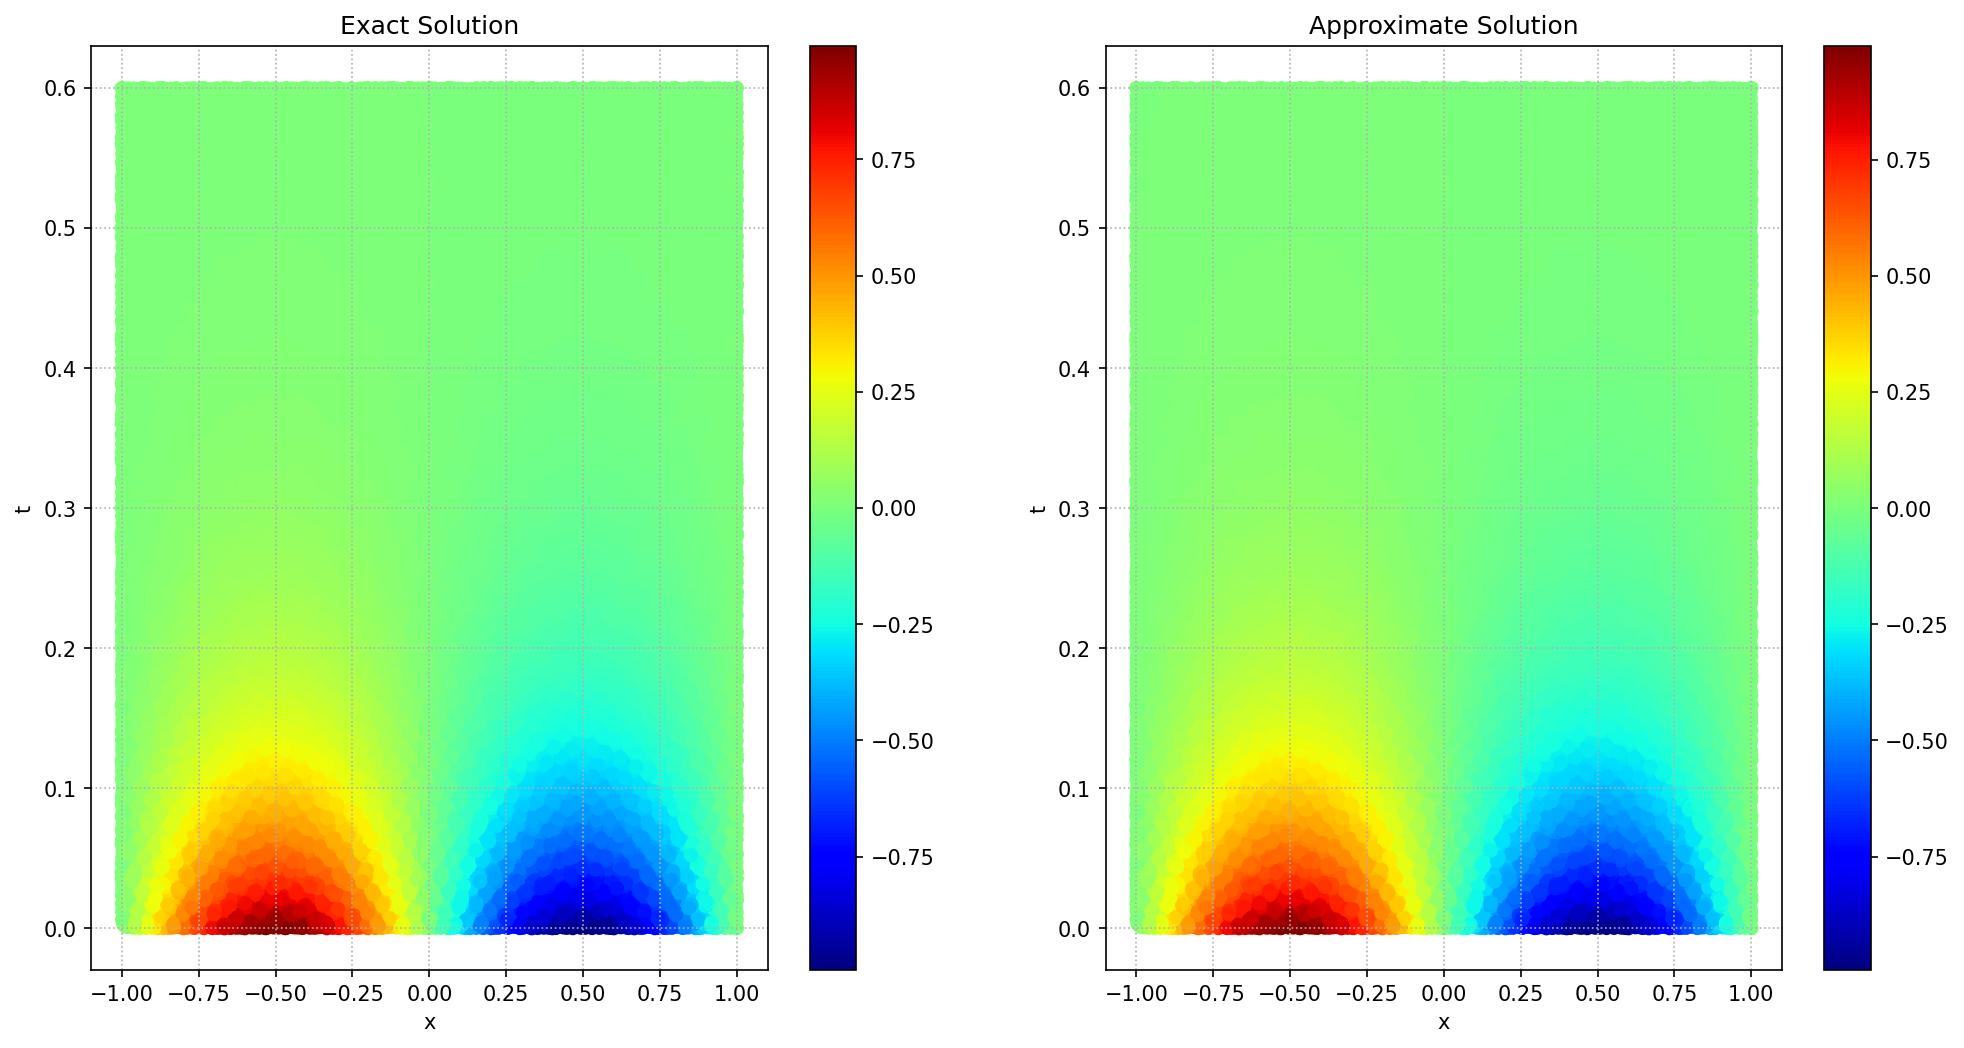

L2 Relative Error Norm:  0.07061528414487839 %


In [7]:
pinn.plotting()